In [32]:
import pandas as pd
import numpy as np

import torch
from  torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm.notebook import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [50]:
params = dict(
    batch_size = 24,
    learning_rate = 1e-3,
    epochs = 50
)

num_asset = 2436

In [4]:
class AE_dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32).to(device)
        self.num_date, self.num_asset = self.data.shape
        
    def __len__(self):
        return self.num_date

    def __getitem__(self, idx):
        return self.data[idx,:]

In [7]:
class AE_model(torch.nn.Module):
    def __init__(self, hidden_dim_1 = 1024, hidden_dim_2 = 512):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_asset, hidden_dim_1),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim_1, hidden_dim_2),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim_2, hidden_dim_1),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim_1, num_asset),
            torch.nn.ReLU()
        )

    def forward(self, data):
        encoded = self.encoder(data)
        decoded = self.decoder(encoded)
        return decoded

In [28]:
data_path = "/content/drive/MyDrive/Colab Data/cl_close_dt.csv"
dataset = pd.read_csv(data_path, index_col=0).pct_change().dropna()

dataset_train, dataset_val = train_test_split(dataset.values, train_size=0.8, shuffle=False)

train_ds = AE_dataset(dataset_train)
val_ds = AE_dataset(dataset_val)

train_dl = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=None)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=None)

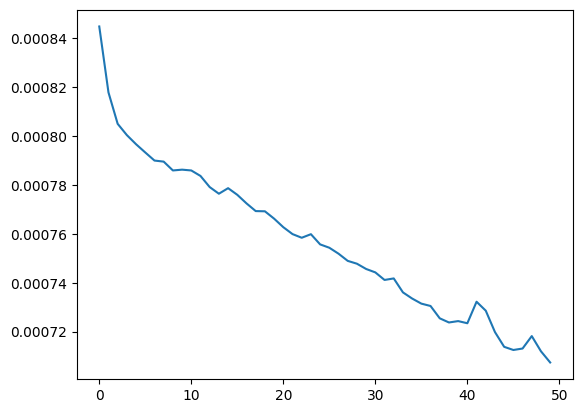

validation loss = 0.0004804453622325257


In [51]:
model = AE_model().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
criterion = F.mse_loss

train_losses = []
val_losses = []

for epoch in tqdm(range(params['epochs'])):
    
    model.train()
    train_losses_per_epoch = []

    for train_batch in train_dl:
        R_target = model(train_batch)
        loss = criterion(R_target, train_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    clear_output(wait=True)
    plt.plot(train_losses)
    plt.show()
    
    model.eval()

val_losses = []

with torch.no_grad():
    for val_batch in val_dl:
        R_target = model(val_batch)
        loss = criterion(R_target, val_batch)
        val_losses.append(loss.item())
print(f"validation loss = {np.mean(val_losses)}")